# **Download from Drive**

---



In [1]:
!gdown --id '1oCCcnLmdHEkMVdIhLIGEvdDuUIcXA87u'

Downloading...
From: https://drive.google.com/uc?id=1oCCcnLmdHEkMVdIhLIGEvdDuUIcXA87u
To: /content/Dataset C.zip
162MB [00:02, 62.6MB/s]


# **Unzip**

---



In [2]:
!unzip '/content/Dataset C.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training-c/c19299.png   
  inflating: training-c/c19300.png   
  inflating: training-c/c19301.png   
  inflating: training-c/c19302.png   
  inflating: training-c/c19303.png   
  inflating: training-c/c19304.png   
  inflating: training-c/c19305.png   
  inflating: training-c/c19306.png   
  inflating: training-c/c19307.png   
  inflating: training-c/c19308.png   
  inflating: training-c/c19309.png   
  inflating: training-c/c19310.png   
  inflating: training-c/c19311.png   
  inflating: training-c/c19312.png   
  inflating: training-c/c19313.png   
  inflating: training-c/c19314.png   
  inflating: training-c/c19315.png   
  inflating: training-c/c19316.png   
  inflating: training-c/c19317.png   
  inflating: training-c/c19318.png   
  inflating: training-c/c19319.png   
  inflating: training-c/c19320.png   
  inflating: training-c/c19321.png   
  inflating: training-c/c19322.png   
  inflating: training-c/c19323.png   

# **Remove Zip**

---



In [3]:
!rm '/content/Dataset C.zip'
print("removed")

removed


# **Imports**

---



In [4]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
!pip install torchviz
from torchviz import make_dot
import PIL
import random
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=8f29ec18298d9bb97b46bce01e06145cec70f56a6b8ef017f4b9af6ce947efec
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [5]:
df = pd.read_csv("training-c.csv")
df = df.loc[:, ['filename','digit']]

# **Data Preprocessing**

---



In [6]:
class processDataset(Dataset):

    def __init__(self, root, image_dir, csv_file, transform=None):
        self.root = root
        self.image_dir = image_dir
        self.image_files = csv_file.iloc[:, 0]
        self.data = csv_file.iloc[:, 1]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = os.path.join(self.image_dir, self.image_files[index])
        image = PIL.Image.open(image_name)
        label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [7]:
root = Path(os.getcwd())
image_dir = root/'training-c'
csv_file = df
mean = [0.5,]
std = [0.5, ]
transform_img = transforms.Compose([
                            transforms.Grayscale(),
                            transforms.Resize(28),
                            # transforms.CenterCrop(28),
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std)
])

In [8]:
dset = processDataset(root, image_dir, csv_file, transform= transform_img)
dset_size = len(dset)
test_perc = 20
test_size = int(dset_size * (test_perc/100))
train_size = dset_size - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dset, [train_size, test_size])

In [9]:
print(dset_size, test_size, train_size)

24298 4859 19439


# **Data Visualization**

---



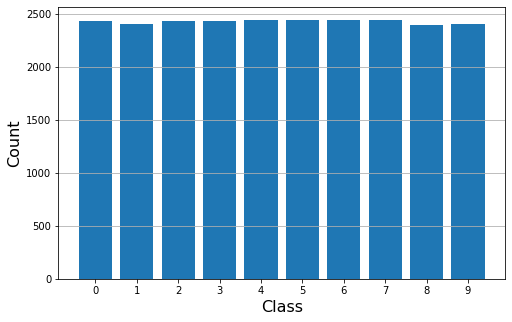

In [10]:
df1 = pd.read_csv("training-c.csv")
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(df1['digit'].value_counts().index, df1['digit'].value_counts())
plt.xticks(np.arange(10))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

Label: 9
Label: 0
Label: 1
Label: 7
Label: 8
Label: 6
Label: 8
Label: 1


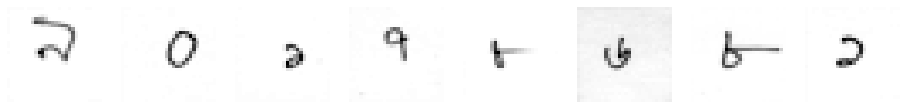

In [11]:
def get_image(image, label, dataset):
    print(f"Label: {label}")
    image = image.permute(1,2,0)
    image = image[:,:,0]
    # plt.imshow(image,cmap='gray')
    # plt.show()
    return image
plt.rcParams['figure.figsize'] = (16, 2)
for i in range(1,9):
  img = get_image(*train_dataset[i], train_dataset)
  plt.subplot(1, 8, i)
  plt.axis('off')
  plt.imshow(img,cmap='gray')
plt.show()

# **EXP_02_trial_1**

---



In [14]:
# Hyperparameters
batch_size = 64
num_iters = 100000
input_dim = 28*28
output_dim = 10
learning_rate = 0.001

In [16]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 512)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(512, 256)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(256, 128)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(128, 32)
        self.relu_4 = nn.ReLU()

        self.linear_out = nn.Linear(32, num_classes)
        self.relu_out = nn.ReLU()

    def forward(self, x):
        
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        probas  = self.linear_out(out)
        probas  = self.relu_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

iter = 0
test_loss_min = 9999999
iter_data,train_loss_data, test_loss_data, acc_data = [], [], [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            train_loss = train_loss / len(train_loader.dataset)
            test_loss = test_loss / len(test_loader.dataset)
            train_loss_data.append(train_loss)
            test_loss_data.append(test_loss)
            accuracy = 100 * correct.item() / total
            acc_data.append(accuracy)
            iter_data.append(iter)

            # Print Loss
            print('Iteration: {}. Train_Loss: {}. Valid_Loss: {}. Accuracy: {}'.format(iter, train_loss, test_loss, accuracy))

            if test_loss <= test_loss_min:
              print('***Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...***'.format(test_loss_min,test_loss))
              torch.save(model.state_dict(), 'EXP_02_trial_2.pt')
              test_loss_min = test_loss

Iteration: 500. Train_Loss: 1.8969414769526929. Valid_Loss: 2.929909261025183. Accuracy: 9.590450710022639
***Validation loss decreased (9999999.000000 --> 2.929909). Saving model ...***
Iteration: 1000. Train_Loss: 0.7556230815952406. Valid_Loss: 2.5602772166685304. Accuracy: 25.993002675447624
***Validation loss decreased (2.929909 --> 2.560277). Saving model ...***
Iteration: 1500. Train_Loss: 2.3548977703363527. Valid_Loss: 2.4771992016976987. Accuracy: 28.31858407079646
***Validation loss decreased (2.560277 --> 2.477199). Saving model ...***
Iteration: 2000. Train_Loss: 1.4053250476714116. Valid_Loss: 2.4201682858762488. Accuracy: 29.759209713932908
***Validation loss decreased (2.477199 --> 2.420168). Saving model ...***
Iteration: 2500. Train_Loss: 0.53296913112827. Valid_Loss: 2.342409480719636. Accuracy: 33.401934554435066
***Validation loss decreased (2.420168 --> 2.342409). Saving model ...***
Iteration: 3000. Train_Loss: 2.0130548819119967. Valid_Loss: 2.251563311702652. A

# **EXP_02_trial_2**

---



In [12]:
# Hyperparameters
batch_size = 64
num_iters = 70000
input_dim = 28*28
output_dim = 10
learning_rate = 0.05

In [13]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 512)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(512,128)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(128,32)
        self.relu_3 = nn.ReLU()


        self.linear_out = nn.Linear(32, num_classes)
        self.relu_out = nn.ReLU()

    def forward(self, x):
        
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)
        
        
        probas  = self.linear_out(out)
        probas  = self.relu_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
test_loss_min = 9999999
iter_data,train_loss_data, test_loss_data, acc_data = [], [], [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            train_loss = train_loss / len(train_loader.dataset)
            test_loss = test_loss / len(test_loader.dataset)
            train_loss_data.append(train_loss)
            test_loss_data.append(test_loss)
            accuracy = 100 * correct.item() / total
            acc_data.append(accuracy)
            iter_data.append(iter)

            # Print Loss
            print('Iteration: {}. Train_Loss: {}. Valid_Loss: {}. Accuracy: {}'.format(iter, train_loss, test_loss, accuracy))

            if test_loss <= test_loss_min:
              print('***Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...***'.format(test_loss_min,test_loss))
              torch.save(model.state_dict(), 'EXP_02_trial_2.pt')
              test_loss_min = test_loss

Iteration: 500. Train_Loss: 2.031940665275228. Valid_Loss: 3.1458913359923675. Accuracy: 14.859024490635933
***Validation loss decreased (9999999.000000 --> 3.145891). Saving model ...***
Iteration: 1000. Train_Loss: 0.8373670661895264. Valid_Loss: 2.941736706443028. Accuracy: 10.53714756122659
***Validation loss decreased (3.145891 --> 2.941737). Saving model ...***
Iteration: 1500. Train_Loss: 2.6762992065687152. Valid_Loss: 2.945722302627014. Accuracy: 11.710228442066269
Iteration: 2000. Train_Loss: 1.4613206644498293. Valid_Loss: 2.493068941533995. Accuracy: 22.96768882486108
***Validation loss decreased (2.941737 --> 2.493069). Saving model ...***
Iteration: 2500. Train_Loss: 0.5480285806232498. Valid_Loss: 2.459725347853757. Accuracy: 20.53920559785964
***Validation loss decreased (2.493069 --> 2.459725). Saving model ...***
Iteration: 3000. Train_Loss: 2.099160105745834. Valid_Loss: 2.4404521293173014. Accuracy: 21.650545379707758
***Validation loss decreased (2.459725 --> 2.440

## **Loss Graph**

---



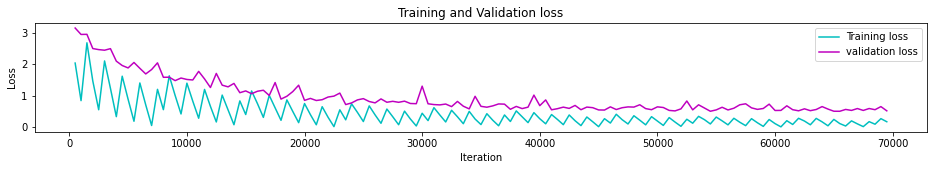

In [14]:
plt.plot(iter_data, train_loss_data, 'c', label='Training loss')
plt.plot(iter_data, test_loss_data, 'm', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Accuracy Graph**

---



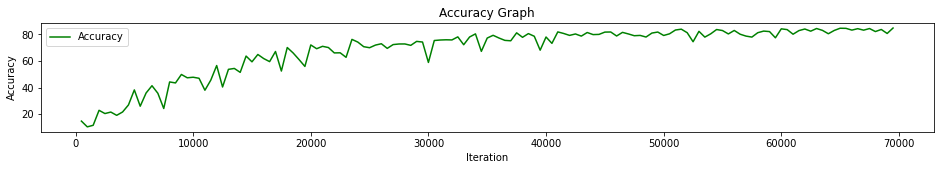

In [15]:
plt.plot(iter_data, acc_data, 'g', label='Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Model Visualization**

---



In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1 = nn.Sequential()
model1.add_module('W0', nn.Linear(28*28, 512))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W1', nn.Linear(512, 256))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W2', nn.Linear(256, 128))
model1.add_module('ReLU', nn.ReLU())
model1.add_module('W3', nn.Linear(128, 10))
model1.add_module('ReLU', nn.ReLU())


xx = torch.randn(32,784)
yy = model1(xx)


make_dot(yy.mean(), params=dict(model1.named_parameters())).render("model1", format="png")

'model1.png'